In [1]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt  
import scipy.interpolate
from scipy.ndimage.interpolation import rotate
from insert import insert

In [2]:
def low_pass_filter(img):
    n0, n1 = img.shape

    x, y = np.mgrid[0:n0, 0:n1]
    x -= n0//2
    y -= n1//2
    r = np.sqrt(x*x + y*y)

    fil = np.fft.ifftshift(np.where(r < 2*min(n0, n1)/3, 1, 0))

    filtered_img = np.fft.ifft2( np.fft.fft2(img) * fil ).real
    return filtered_img

def slices_gen(img, thetas):
    l_max = np.max(img.shape)
    slices = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        mid = rotated_img[rotated_img.shape[0]//2, :]
        pad_width = [int(np.floor(l_max - len(mid))/2.), int(np.ceil((l_max - len(mid))/2.))]
        mid = np.pad(mid, pad_width, mode = "constant", constant_values = 0)
        slices[i] = mid
    return slices

def radon(img, thetas):
    l_max = np.max(img.shape)
    sinogram = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        proj = np.sum(rotated_img, axis = 0)
        pad_width = [int(np.floor(l_max - len(proj))/2.), int(np.ceil((l_max - len(proj))/2.))]
        proj = np.pad(proj, pad_width, mode = "constant", constant_values = 0)
        sinogram[i] = proj
    return sinogram.T

def iradon(sinogram, thetas):
    n0, n1 = sinogram.shape
    assert(n1 == len(thetas))
    thetas = thetas / 180 * np.pi
    fil = np.abs(np.fft.fftfreq(n0)).reshape((-1, 1))
    filtered_sino = np.fft.ifft(np.fft.fft(sinogram, axis = 0) * fil, axis = 0).real

    x, y = np.mgrid[0:n0,0:n0]
    x -= n0//2
    y -= n0//2
    t = np.arange(n0) - n0//2

    recon = np.zeros([n0,n0], dtype = np.float64)
    for i,theta in enumerate(thetas):
        tt = -x*np.sin(theta) + y*np.cos(theta)
        back_proj = np.interp(tt, t, filtered_sino[:, i])
        recon += back_proj
    return recon

def recon_f(sinogram, thetas):
    n0, n1 = sinogram.shape

    x, y = np.mgrid[0:n0, 0:n0]
    x -= n0//2
    y -= n1//2
    r = np.sqrt(x*x + y*y)

    fil = np.fft.ifftshift(np.where(r < 2*n0/3, 1, 0))
    # fil = 1 #np.abs(np.fft.fftfreq(n0)).reshape((-1, 1))
    ft_sino = np.fft.fftshift( np.fft.fft(sinogram, axis = 0), axes = 0 )
    slices_real = np.real(ft_sino).T
    slices_imag = np.imag(ft_sino).T

    model_real = insert(slices_real, thetas)
    model_imag = insert(slices_imag, thetas)

    model = model_real + 1j*model_imag
    # model *= fil

    recon = np.fft.ifft2(np.fft.ifftshift(model)).real

    return model, recon

In [3]:
### Construct phantom
phantom = np.load("phantom_small.npy")
# X, Y = np.mgrid[-5*np.pi:5*np.pi:64*1j, -5*np.pi:5*np.pi:64*1j]

# y1 = np.sin(X)
# y2 = np.sin(X/np.sqrt(2) + Y/np.sqrt(2))

# phantom = y1 + y2

# phantom = np.pad(phantom, pad_width = [[100,101],[100,101]], mode = "constant", constant_values = 0)
phantom = low_pass_filter(phantom)
thetas = np.arange(0, 180, 1)
thetas = np.asarray(thetas, dtype = np.float64)

In [4]:
sinogram = radon(phantom, thetas)

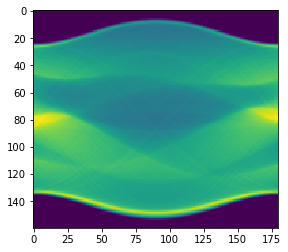

In [5]:
plt.imshow(sinogram)

In [6]:
recon_fbp = iradon(sinogram, thetas)

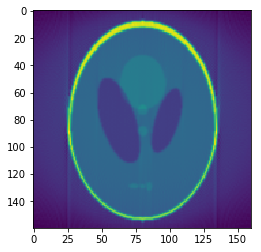

In [7]:
plt.imshow(recon_fbp)

In [8]:
model, recon_insertion = recon_f(sinogram, thetas)

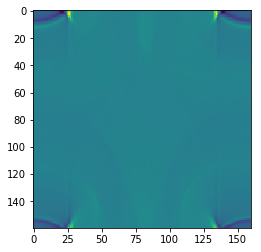

In [9]:
plt.imshow(recon_insertion)

In [10]:
slices = slices_gen(phantom, thetas)

In [11]:
recon_real = insert(slices, thetas)

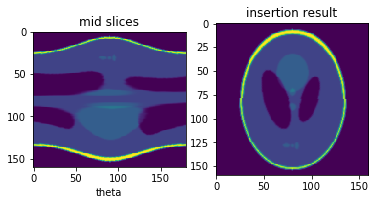

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.imshow(slices.T)
ax1.set_title("mid slices")
ax1.set_xlabel("theta")
ax2.imshow(recon_real)
ax2.set_title("insertion result")
plt.savefig( '/Users/xinchen/Workspace/image_recon/imgs/mid_slice_insertion.png')